# Example of usage Spark OCR for Handwritten Text Recognition by ImageToTextV2

This notebook demonstrate pipeline for detect handwritten text using __ImageTextDetectorV2__ and text recognition using __ImageToTextV2__ on the image.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"

In [ ]:
# install from PYPI using secret
%pip install torch
%pip install transformers==4.16.2
%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session

In [2]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.0.2
Spark OCR version: 3.12.0



# Read image and display it

In [3]:
import pkg_resources
import pyspark.sql.functions as f
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/test.png
    Resolution: 0 dpi
    Width: 543 px
    Height: 205 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


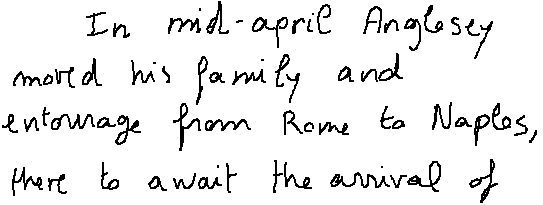

In [7]:
imagePath = '../data/handwritten/test.png'
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [15]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True) \
    .setSizeThreshold(10)

ocr = ImageToTextV2.pretrained("ocr_small_handwritten", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setGroupImages(True) \
    .setOutputCol("text")

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_handwritten download started this may take some time.
Approximate size to download 139.9 MB


# Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/test.png
    Resolution: 0 dpi
    Width: 543 px
    Height: 205 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


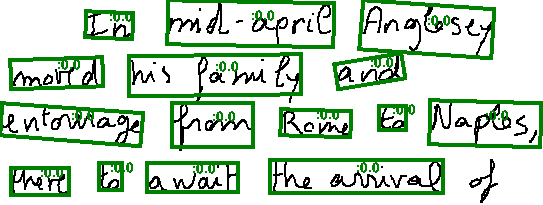

In mid-appil. Anglosey
removed his family and
tentourage from Rome to Naples,
there to await if the arrival


In [16]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")
print(("").join([x.text for x in result.select("text").collect()]))